### Setting paths and imports

In [1]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)
module_path

'c:\\Users\\sever\\GRETEL'

In [2]:
os.chdir(module_path)

In [6]:
from src.utils.context import Context
from src.dataset.dataset_factory import DatasetFactory

config_path = 'hpsearch\config\DBLP_v1_GCN_iRand_hp_tuning.jsonc'    
print(f"Generating context for: {config_path}")
context = Context.get_context(config_path)

context.factories['datasets'] = DatasetFactory(context)

Generating context for: hpsearch\config\DBLP_v1_GCN_iRand_hp_tuning.jsonc


In [11]:
do_pairs_list = context.conf['do-pairs']
dataset_config = do_pairs_list[0]['dataset']
dataset = context.factories['datasets'].get_dataset(dataset_config)

2024-09-01 16:59:30,-1374082520 | INFO | 9040 - Creating: DBLP-838f866e8a4b3b5b8450c82c7004e350
2024-09-01 16:59:30,-1374082520 | INFO | 9040 - Instantiating: src.dataset.generators.dblp_v1.DBLP
2024-09-01 17:08:44,-1373528021 | INFO | 9040 - Apply: src.dataset.manipulators.centralities.NodeCentrality
2024-09-01 17:08:44,-1373528021 | INFO | 9040 - Instantiating: src.dataset.manipulators.centralities.NodeCentrality
2024-09-01 17:09:12,-1373500426 | INFO | 9040 - Apply: src.dataset.manipulators.weights.EdgeWeights
2024-09-01 17:09:12,-1373500425 | INFO | 9040 - Instantiating: src.dataset.manipulators.weights.EdgeWeights
2024-09-01 17:09:13,-1373499691 | INFO | 9040 - Saved: DBLP-838f866e8a4b3b5b8450c82c7004e350
2024-09-01 17:09:13,-1373499637 | INFO | 9040 - Created: DBLP-838f866e8a4b3b5b8450c82c7004e350


(4, 4)
Node features: 
 [[ 6.4611365e-03  3.0000000e+00  0.0000000e+00  1.0000000e+00
   3.0000000e+00  1.0000000e+00  5.0000000e-01 -5.9604645e-08]
 [ 2.2021101e-03  3.0000000e+00  0.0000000e+00  1.0000000e+00
   3.0000000e+00  1.0000000e+00  5.0000000e-01  4.0000000e+00]
 [ 6.4853355e-03  3.0000000e+00  0.0000000e+00  1.0000000e+00
   3.0000000e+00  1.0000000e+00  5.0000000e-01  4.0000000e+00]
 [ 3.7024489e-03  3.0000000e+00  0.0000000e+00  1.0000000e+00
   3.0000000e+00  1.0000000e+00  5.0000000e-01  4.0000000e+00]]
Edge features: 
 [[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


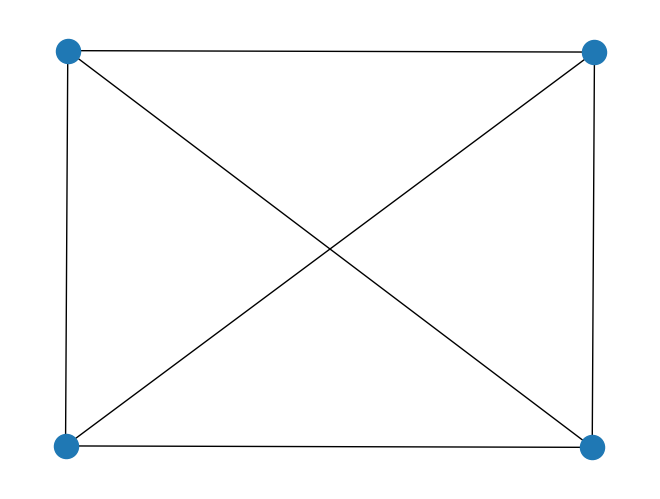

In [66]:
import networkx as nx

graph_instance = dataset.get_instance(12)
print(graph_instance.data.shape)
print("Node features: \n", graph_instance.node_features)
print("Edge features: \n", graph_instance.edge_features)
G = graph_instance.get_nx()
nx.draw(G)

In [73]:
graph_instance.node_features

array([[ 6.4611365e-03,  3.0000000e+00,  0.0000000e+00,  1.0000000e+00,
         3.0000000e+00,  1.0000000e+00,  5.0000000e-01, -5.9604645e-08],
       [ 2.2021101e-03,  3.0000000e+00,  0.0000000e+00,  1.0000000e+00,
         3.0000000e+00,  1.0000000e+00,  5.0000000e-01,  4.0000000e+00],
       [ 6.4853355e-03,  3.0000000e+00,  0.0000000e+00,  1.0000000e+00,
         3.0000000e+00,  1.0000000e+00,  5.0000000e-01,  4.0000000e+00],
       [ 3.7024489e-03,  3.0000000e+00,  0.0000000e+00,  1.0000000e+00,
         3.0000000e+00,  1.0000000e+00,  5.0000000e-01,  4.0000000e+00]],
      dtype=float32)